# Lab 2 - Regression, DiD, and Fixed Effects
- **Author:** Suraj R. Nair ([suraj.nair@berkeley.edu](mailto:suraj.nair@berkeley.edu)) (based on past labs by Emily Aiken, Qutub Khan Vajihi and Dimitris Papadimitriou)
- **Date:** February 24, 2024
- **Course:** INFO 251: Applied machine learning

### Topics:
1. Linear/ Multivariate Regression
2. Dummy variables
3. Exercises

### References: 
 * [Statsmodels](http://www.statsmodels.org/stable/example_formulas.html#loading-modules-and-functions) 
 * [Interpreting regression coefficients](https://dss.princeton.edu/online_help/analysis/interpreting_regression.htm)
 * [Card and Krueger (1994)](https://davidcard.berkeley.edu/papers/njmin-aer.pdf)
 * Fixed Effects:
      - [Panel Data and Fixed Effects in Python](https://matheusfacure.github.io/python-causality-handbook/14-Panel-Data-and-Fixed-Effects.html)
      - [Notes](https://www.jblumenstock.com/files/courses/econ174/FEModels.pdf) on fixed effects

### Import libraries

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline  

# The packages you'll need for regression models
import statsmodels.api as sm
import statsmodels.formula.api as smf

### 1. Load the data

Card and Krueger (1994) collected survey data on employment in fast food restaurants in New Jersey and Pennsylvania in 1992. The data for today's lab uses a subset of the variables they collected.

- *UNIQUE_ID*: Unique ID for the restaurant interviewed
- *PERIOD*: 0 for pre-period (March 1994), 1 for post-period (December 1994)
- *STATE*: 0 for Pennsylvania, 1 for New Jersey
- *REGION*: Region code: 1 = Southern NJ, 2 = Central NJ, 3 = Northern NJ, 4 = Northeast Philly suburbs, 5 = Easton area, 6 = NJ Shore
- *CHAIN*: Chain restaurant code: 1 = Burger King, 2 = KFC, 3 = Roy's, 4 = Wendy's
- *EMP*: Number of employees (fulltime or parttime)
- *CO_OWNED*: 1 if company-owned
- *BONUS*: 1 if employees get a signing bonus
- *HRSOPEN*: Hours open per day, up to 24
- *NREGS*: Number of registers

In [2]:
df = pd.read_csv('fastfood.csv')
df.head()

,UNIQUE_ID,PERIOD,STATE,REGION,CHAIN,EMP,CO_OWNED,BONUS,HRSOPEN,NREGS
0,46.0,0,0.0,4,1.0,45.0,0.0,1.0,16.5,3.0
1,49.0,0,0.0,4,2.0,13.0,0.0,0.0,13.0,4.0
2,506.0,0,0.0,4,2.0,10.0,1.0,0.0,10.0,3.0
3,56.0,0,0.0,4,4.0,40.0,1.0,1.0,12.0,2.0
4,61.0,0,0.0,4,4.0,32.0,1.0,1.0,12.0,2.0


In [3]:
df.tail()

,UNIQUE_ID,PERIOD,STATE,REGION,CHAIN,EMP,CO_OWNED,BONUS,HRSOPEN,NREGS
785,423.0,1,1.0,3,2.0,22.5,1.0,1.0,12.0,3.0
786,424.0,1,1.0,3,2.0,15.0,1.0,0.0,11.0,5.0
787,426.0,1,1.0,3,3.0,30.0,1.0,0.0,19.0,5.0
788,427.0,1,1.0,3,4.0,35.0,0.0,0.0,12.5,2.0
789,428.0,1,1.0,3,4.0,34.0,0.0,0.0,12.5,2.0


In [4]:
#Create a variable identifying the pre-treatment period
pre = df[df['PERIOD'] == 0].copy()
post = df[df['PERIOD'] == 1].copy()

### 2. Univariate Regression

Linear regression provides us a concise summary of one variable as a function of another variables(s) through two types of parameters - the slope and the intercept. To review linear regression, we'll start by exploring the relationship between employment and the number of hours a restaurant is open
in the pre-period.

#### 2.1 Exploratory analysis

In [5]:
# Find the correlation between number of rooms and median housing price.
np.corrcoef(pre['HRSOPEN'], pre['EMP'])[0][1]

#Pandas also has a built correlation function
# pre[['HRSOPEN', 'EMP']].corr()

0.5607581039654647

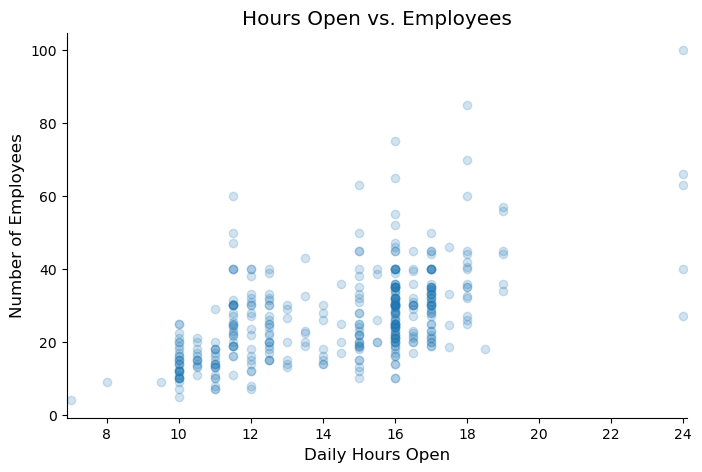

In [6]:
fig = plt.figure(figsize=(8, 5))
plt.scatter(pre['HRSOPEN'], pre['EMP'], alpha=.2)
plt.xlabel('Daily Hours Open', fontsize='large')
plt.ylabel('Number of Employees', fontsize='large')
plt.title('Hours Open vs. Employees', fontsize='x-large')
plt.xlim(6.9, 24.1)
sns.despine()
plt.show()

#### 2.2 Estimating a regression with np.polyfit

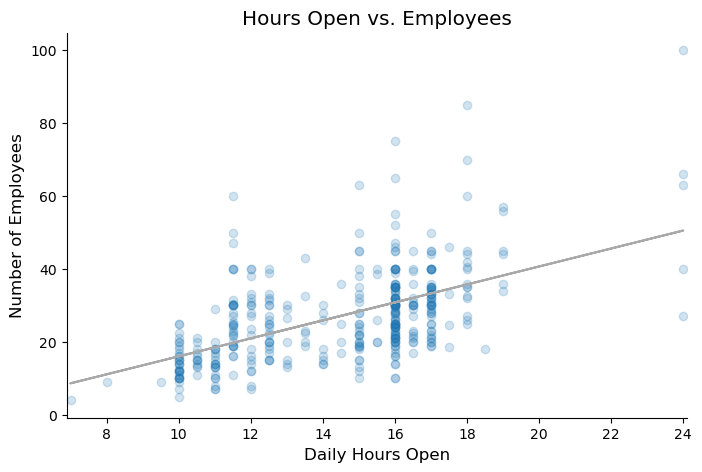

In [7]:
# Estimate the regression
x, y = pre['HRSOPEN'].values, pre['EMP'].values # x is the input variable, y is the output variable
slope, intercept = np.polyfit(x, y, 1) # 1 is the degree

# Scatterplot with the regression line
fig = plt.figure(figsize=(8, 5))
plt.scatter(pre['HRSOPEN'], pre['EMP'], alpha=.2)
plt.plot(x, slope*x + intercept, color='darkgrey')
plt.xlabel('Daily Hours Open', fontsize='large')
plt.ylabel('Number of Employees', fontsize='large')
plt.title('Hours Open vs. Employees', fontsize='x-large')
plt.xlim(6.9, 24.1)
sns.despine()
plt.show()

#### 2.3 Interpretation of the slope and intercept

In [8]:
print(f'The slope of the line is {np.round(slope, 3)}')

The slope of the line is 2.466


**Question**: How would you interpret this value?

In [9]:
print(f'The intercept of the line is {np.round(intercept, 3)}')

The intercept of the line is -8.628


**Question**: How would you interpret this value?

#### 2.4 Estimating a regression with statsmodels

In [10]:
# Syntax option 1
x, y = pre['HRSOPEN'].values, pre['EMP'].values # x is the input variable, y is the output variable
x = sm.add_constant(x) # Add a constant for the intercept term
model1 = sm.OLS(y, x).fit() # Note the order of y folowed by x!
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     182.1
Date:                Thu, 01 Feb 2024   Prob (F-statistic):           2.02e-34
Time:                        15:55:31   Log-Likelihood:                -1494.8
No. Observations:                 399   AIC:                             2994.
Df Residuals:                     397   BIC:                             3002.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.6277      2.689     -3.209      0.0

In [11]:
# Syntax option 2
model2 = smf.ols(formula='EMP ~ HRSOPEN', data=pre).fit() # Automatically includes the intercept term
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    EMP   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     182.1
Date:                Thu, 01 Feb 2024   Prob (F-statistic):           2.02e-34
Time:                        15:55:31   Log-Likelihood:                -1494.8
No. Observations:                 399   AIC:                             2994.
Df Residuals:                     397   BIC:                             3002.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.6277      2.689     -3.209      0.0

### 2. Categorical Data

Now, we'll experiment with categorical data by examining the relationship between EMPTOT (the number of employees) and CHAIN (the fast food chain category) in the pre-period.

In [12]:
# Check values of CHAIN
pre['CHAIN'].value_counts()

1.0    166
3.0     98
2.0     78
4.0     57
Name: CHAIN, dtype: int64

In [13]:
# Get dummy variables for CHAIN
dummy_pre = pd.get_dummies(pre, columns=['CHAIN']).head() # Pandas' default is not to drop a column
dummy_pre.head()

,UNIQUE_ID,PERIOD,STATE,REGION,EMP,CO_OWNED,BONUS,HRSOPEN,NREGS,CHAIN_1.0,CHAIN_2.0,CHAIN_3.0,CHAIN_4.0
0,46.0,0,0.0,4,45.0,0.0,1.0,16.5,3.0,1,0,0,0
1,49.0,0,0.0,4,13.0,0.0,0.0,13.0,4.0,0,1,0,0
2,506.0,0,0.0,4,10.0,1.0,0.0,10.0,3.0,0,1,0,0
3,56.0,0,0.0,4,40.0,1.0,1.0,12.0,2.0,0,0,0,1
4,61.0,0,0.0,4,32.0,1.0,1.0,12.0,2.0,0,0,0,1


In [14]:
# Get dummy variables for CHAIN and drop one column
dummy_pre = pd.get_dummies(pre, columns=['CHAIN'], drop_first=True).head() # Drop a column
dummy_pre.head()

,UNIQUE_ID,PERIOD,STATE,REGION,EMP,CO_OWNED,BONUS,HRSOPEN,NREGS,CHAIN_2.0,CHAIN_3.0,CHAIN_4.0
0,46.0,0,0.0,4,45.0,0.0,1.0,16.5,3.0,0,0,0
1,49.0,0,0.0,4,13.0,0.0,0.0,13.0,4.0,1,0,0
2,506.0,0,0.0,4,10.0,1.0,0.0,10.0,3.0,1,0,0
3,56.0,0,0.0,4,40.0,1.0,1.0,12.0,2.0,0,0,1
4,61.0,0,0.0,4,32.0,1.0,1.0,12.0,2.0,0,0,1


In [15]:
# Regression with a dummy variable: Syntax option 1
x = pd.get_dummies(pre[['CHAIN']], columns=['CHAIN'], drop_first=True)
x = sm.add_constant(x)
y = pre['EMP']
print(sm.OLS(y, x).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    EMP   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     39.61
Date:                Thu, 01 Feb 2024   Prob (F-statistic):           2.12e-22
Time:                        15:55:31   Log-Likelihood:                -1517.6
No. Observations:                 399   AIC:                             3043.
Df Residuals:                     395   BIC:                             3059.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.4759      0.847     35.989      0.0

**Exercise**: 

- How do we interpret the coefficients on the variable(s) CHAIN?

In [16]:
# Regression with a dummy variable: Syntax option 2

# Statsmodels formula API automatically drops one of the dummies
print(smf.ols(formula='EMP ~ C(CHAIN)', data=pre).fit().summary()) 

                            OLS Regression Results                            
Dep. Variable:                    EMP   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     39.61
Date:                Thu, 01 Feb 2024   Prob (F-statistic):           2.12e-22
Time:                        15:55:31   Log-Likelihood:                -1517.6
No. Observations:                 399   AIC:                             3043.
Df Residuals:                     395   BIC:                             3059.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          30.4759      0.847     

 - Now run the regression again, this time dropping the constant. What do you observe? How have the coefficients changed?

In [17]:
# Alternative: drop the constant
print(smf.ols(formula='EMP ~ C(CHAIN) - 1', data=pre).fit().summary()) 

                            OLS Regression Results                            
Dep. Variable:                    EMP   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     39.61
Date:                Thu, 01 Feb 2024   Prob (F-statistic):           2.12e-22
Time:                        15:55:31   Log-Likelihood:                -1517.6
No. Observations:                 399   AIC:                             3043.
Df Residuals:                     395   BIC:                             3059.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
C(CHAIN)[1.0]    30.4759      0.847     35.989

### 3. Multivariate Regression

Now let's look at some other covariates: The number of registrations, whether or not employees get a bonus, and the region.

In [18]:
# Syntax 1
X = sm.add_constant(pre[['HRSOPEN', 'NREGS', 'BONUS']]) # X is capitalized since it's now a matrix
y = pre['EMP']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    EMP   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     67.08
Date:                Thu, 01 Feb 2024   Prob (F-statistic):           4.46e-35
Time:                        15:55:31   Log-Likelihood:                -1488.0
No. Observations:                 399   AIC:                             2984.
Df Residuals:                     395   BIC:                             3000.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.7277      2.829     -3.439      0.0

# Syntax 2
model = smf.ols(formula='EMP ~ HRSOPEN + NREGS + C(REGION)', data=pre).fit()
print(model.summary())

In [19]:
model = smf.ols(formula='EMP ~ HRSOPEN + NREGS + C(REGION)', data=pre).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    EMP   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     36.42
Date:                Thu, 01 Feb 2024   Prob (F-statistic):           4.93e-35
Time:                        15:55:31   Log-Likelihood:                -1481.7
No. Observations:                 399   AIC:                             2977.
Df Residuals:                     392   BIC:                             3005.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -10.9948      2.816     -3.

**QUESTION**: Interpret each of the regression coefficients.

# Exercises:


1. On average, prior to the wage increase, is the average employment in New Jersy and Pennsylvania similar? 

In [20]:
pre[pre['STATE'] == 0]['EMP'].mean()-pre[pre['STATE'] == 1]['EMP'].mean()

3.3683201533668843

2. Calculate the average change in employment, for the following groups (difference in means):
    
    - Pennsylvania v/s New Jersey (Post-period only, i.e PERIOD = 1)
    - Pennsylvania v/s New Jersey (Pre-period only, i.e PERIOD = 0)
    - Pre v/s Post in Pennsylvania
    - Pre v/s Post in New Jersey 
    - Differences-in-difference

In [21]:
print(post[post['STATE'] == 0]['EMP'].mean()-post[post['STATE'] == 1]['EMP'].mean())
print(pre[pre['STATE'] == 0]['EMP'].mean()-pre[pre['STATE'] == 1]['EMP'].mean())
print(pre[pre['STATE'] == 0]['EMP'].mean()-post[post['STATE'] == 0]['EMP'].mean())
print(pre[pre['STATE'] == 1]['EMP'].mean()-post[post['STATE'] == 1]['EMP'].mean())
print((pre[pre['STATE'] == 0]['EMP'].mean()-post[post['STATE'] == 0]['EMP'].mean())-(pre[pre['STATE'] == 1]['EMP'].mean()-post[post['STATE'] == 1]['EMP'].mean()))

0.7609857978279031
3.3683201533668843
2.2186234817813784
-0.3887108737576028
2.607334355538981


3. Now, let's do the same thing, but using linear regression! Let's focus on differences between Pennsylvania and New Jersey in the pre-period only. What do you observe?



In [22]:
print(smf.ols(formula='EMP ~ C(STATE)', data=pre).fit().summary()) 

                            OLS Regression Results                            
Dep. Variable:                    EMP   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4.675
Date:                Thu, 01 Feb 2024   Prob (F-statistic):             0.0312
Time:                        15:55:31   Log-Likelihood:                -1567.8
No. Observations:                 399   AIC:                             3140.
Df Residuals:                     397   BIC:                             3148.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          29.6923      1.397     

4. Let's see what happens when we add a control variable. Let's control for the number of hours (HRSOPEN) 

In [23]:
model = smf.ols(formula='EMP ~ HRSOPEN + C(STATE)', data=pre).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    EMP   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     95.46
Date:                Thu, 01 Feb 2024   Prob (F-statistic):           1.46e-34
Time:                        15:55:31   Log-Likelihood:                -1491.6
No. Observations:                 399   AIC:                             2989.
Df Residuals:                     396   BIC:                             3001.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -5.9680      2.871     

5. Plot the regression line/ line of best fit in the treatment and the control groups

6. Let's finish with a visual assessment of trends in EMP before and after the wage increase, in T and C

In [24]:

# Let's calculate the mean for the pre and post periods, in both the treatment and control groups. 
control_pre = 
treatment_pre = 
control_post = 
treatment_post = 


# Now, let's plot this. 
fig = plt.figure(figsize=(8, 5))
plt.scatter([0, 1], [control_pre, control_post], s=200)
plt.plot([0, 1], [control_pre, control_post], label='Control (Pennsylvania)')
plt.scatter([0, 1], [treatment_pre, treatment_post], s=200)
plt.plot([0, 1], [treatment_pre, treatment_post], label='Treatment (New Jersey)')
plt.legend(loc='best', fontsize='large')
plt.xlabel('Time (Pre vs. Post)', fontsize='large')
plt.ylabel('Average Employees', fontsize='large')
plt.title('Employees Over Time', fontsize='x-large')
plt.show()


SyntaxError: invalid syntax (669012914.py, line 2)

## FOR NEXT WEEK

### Differences-in-differences


Use a differences-in-differences regression specification to estimate the impact of the increase in the minimum wage in New Jersey (state == 1) between the pre- and the post-period (period==1). 

Remember the diff-in-diff regression specification: Y = B0 + B1 * Time + B2 * Intervention + B3*(Time*Intervention)

**QUESTION**: Interpret the regression coefficients in terms of the impact of the minimum wage change on employment.

**QUESTION**: Why might you want to add control variables to this regression?

### 5. Interaction Terms

An interaction term captures the notion that the value of a variable is influenced by the value of another variables. 

In [ ]:
model1 = smf.ols(formula='EMP ~ HRSOPEN + BONUS + HRSOPEN * BONUS ', data=pre).fit()
print(model1.summary())

**QUESTION**: Interpret the coefficients

**QUESTION**: Create a plot which demonstrates how the variable BONUS influences the value of HRSOPEN

### 6: Fixed Effects Intuition

Let's create a toy dataset for this example, with these variables:

    - city: New York, Chicago, San Francisco, Washington D.C
    - year: 2020, 2021, 2022, 2023, 2024
    - quantity: the amount purchased (of some arbitrary good)
    - price: the cost of the arbitrary good, varying by year and city. 
   

In [ ]:

df_panel = pd.DataFrame({
    "quantity": [25, 24.3, 23, 20,
                 15, 13.8, 12.5, 13,
                 20, 19, 18, 19,
                 22, 19.5, 19, 19,
                ],
    "price": [5.0, 5.34, 5.47, 5.51, 
              4.01, 4.35, 4.43, 4.43, 
              4.50, 4.62, 4.70, 4.89, 
             4.80, 4.90, 4.95, 5.25
             ],
    "year":[2020, 2021, 2022, 2023]*4,
    "city":  ['New York']*4 +  
             ["Chicago"]*4 + 
             ["San Francisco"]*4 + 
             ["Washington D.C."]*4
})


Let's explore a cross-section of this data, say in the year 2022.  

In [ ]:
### View the data

df_panel[df_panel['year'] == 2022]

Simply looking over this data, it actually appears the quantity purchased appears to increase along with prices. Does that make sense?. 

What might explain this? On the one hand, perhaps the quality of the good is higher in certain cities. For example, if the **good** in question is a bagel, perhaps the best bagels are found in New York (ahem, Boichik)? Alternatively, there might simply be a high demand for bagels in New York, thus explaining the high prices. 

But simply put, we can't say much about the role of price here -- since we do not have data for quality, or bagel obsession.. Running a regression to further examine the relationship between quantity and price is likely to thus suffer from omitted variable bias.

To hammer home this point, let's explore the relationship between quantity and price using a univariate regression, across the entire sample. What do you get?

In [ ]:
m = smf.ols("quantity ~ price", data = df_panel).fit()

sns.scatterplot(data = df_panel, x=  'price', y = 'quantity', hue = "city")
plt.plot(df_panel['price'], m.fittedvalues, "k-", alpha = 0.5, label="Regression Line")
plt.xlabel("Price")
plt.ylabel("Quantity")
sns.despine()
plt.show()

Now, let's examine the full dataset. 

In [ ]:
df_panel

We see that as price increases, the quantity purchased decreases **within** each city. This is reasonable, as we would expect the demand to fall as price increases.

This provides the underlying intuition for fixed effects. In the cross-section we saw earlier, a regression that primarily relied on variation across cities is problematic, due to omitted variables bias. The solution is to focus on **within** city variation, relying on the panel structure of the data to remove the effect of omitted variable bias.

We still have to make a key assumption here, however. What is it?

Now, let's examine a simple fixed effects model, where we eliminate the unobserved variation across cities, and focus only on within city variation. A simple way to achieve this, as you saw in lecture, is to add a dummy variable for each city. So let's go ahead and try that below. 

In [ ]:
#C() is used to tell statsmodels that the variable in question is a categorical/ factor variable
fe = smf.ols("quantity ~ price + C(city)", data=df_panel).fit()  

df_panel['y_hat'] = fe.fittedvalues

sns.scatterplot(data = df_panel, x = 'price', y = 'quantity', hue = 'city')
for city in df_panel["city"].unique():
    plt_df = df_panel[df_panel["city"] == city]
    plt.plot(plt_df['price'], plt_df['y_hat'], "k-", alpha = 0.5)

plt.title("Fixed Effect Model")
plt.xlabel("Quantity")
plt.ylabel("Price")
plt.legend(loc = "best")
sns.despine()
plt.show()

Notice that we are effectively fitting one regression line per city. This is what the ''city'' fixed effect does -- it controls for the average (time invariant) differences across cities (in observable/ unobservable variables). 